<a href="https://colab.research.google.com/github/rajdepot/computerVision/blob/main/Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# run once at the top of the notebook
!pip install --upgrade pip
!pip install pandas numpy scikit-learn matplotlib seaborn joblib tqdm
!pip install nltk
# optional heavy libs (only if you plan to use TF/CNN/Transformers)
!pip install tensorflow         # installs TF (CPU/GPU automatically uses GPU if available)
!pip install transformers datasets accelerate


In [ ]:
# Cell 1 - Setup: install packages and mount Google Drive
# Run once at the top of your Colab notebook.

!pip install --upgrade pip
!pip install pandas numpy scikit-learn matplotlib seaborn joblib tqdm nltk kaggle

# Mount Drive
from google.colab import drive
drive.mount('/content/drive')

# Create working folder in Drive
import os
WORKDIR = "/content/drive/MyDrive/sentiment_project"
os.makedirs(WORKDIR, exist_ok=True)
print("Working directory:", WORKDIR)

# Upload kaggle.json if you need to download from Kaggle (run this cell and follow the upload prompt)
from google.colab import files
print("\nIf you have kaggle.json, upload it now (Kaggle API token). If not, skip and we'll use demo data later.")
_ = files.upload()  # upload kaggle.json when prompted (optional)


MessageError: Error: credential propagation was unsuccessful

In [ ]:
# Cell 2 - download Sentiment140 (public)
import os
os.chdir("/content")
if not os.path.exists("training.1600000.processed.noemoticon.csv"):
    print("Downloading Sentiment140...")
    !wget -q --show-progress https://cs.stanford.edu/people/alecmgo/trainingandtestdata.zip -O trainingandtestdata.zip
    !unzip -o trainingandtestdata.zip
else:
    print("Already downloaded.")

print("Files in /content:", [f for f in os.listdir("/content") if "training" in f.lower() or f.endswith('.zip')][:20])


trainingandtestdata 100%[===================>]  77.59M  18.1MB/s    in 5.6s    
Archive:  trainingandtestdata.zip
  inflating: testdata.manual.2009.06.14.csv  
  inflating: training.1600000.processed.noemoticon.csv  
Files in /content: ['training.1600000.processed.noemoticon.csv', 'trainingandtestdata.zip']


In [ ]:
# Cell 3 - load & preprocess Sentiment140
import pandas as pd
import re
from pathlib import Path

DATA_FILE = "/content/training.1600000.processed.noemoticon.csv"

# columns: [sentiment, id, date, query, user, text]
print("Loading CSV (this may take 20-60s for 1.6M rows)...")
df = pd.read_csv(DATA_FILE, encoding='latin-1', header=None, names=['sentiment','id','date','query','user','text'])

# Map sentiment: 0 -> negative, 4 -> positive
print("Original label distribution (first):")
print(df['sentiment'].value_counts().to_dict())

# Convert to binary labels 0=negative, 1=positive
df['label'] = df['sentiment'].map({0:0, 4:1})

# simple cleaning function
def clean_text(s: str) -> str:
    if pd.isna(s):
        return ""
    s = str(s)
    s = re.sub(r"http\S+|www\S+", "", s)   # remove urls
    s = re.sub(r"@\w+", "", s)             # remove mentions
    s = re.sub(r"[^A-Za-z0-9\s]", " ", s)  # remove punctuation
    s = re.sub(r"\s+", " ", s).strip()
    return s.lower()

# create cleaned text column
print("Cleaning text (this may take a while)...")
df['text_clean'] = df['text'].astype(str).apply(clean_text)

# Show small sample
print("Sample:")
display(df[['text','text_clean','label']].head(3))


Loading CSV (this may take 20-60s for 1.6M rows)...
Original label distribution (first):
{0: 800000, 4: 800000}
Cleaning text (this may take a while)...
Sample:


,text,text_clean,label
0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",a that s a bummer you shoulda got david carr o...,0
1,is upset that he can't update his Facebook by ...,is upset that he can t update his facebook by ...,0
2,@Kenichan I dived many times for the ball. Man...,i dived many times for the ball managed to sav...,0


Train / Test sizes: 1280000 320000
Train label counts:
 label
1    640000
0    640000
Name: count, dtype: int64
Test label counts:
 label
0    160000
1    160000
Name: count, dtype: int64
Training LogisticRegression...

Classification report:
              precision    recall  f1-score   support

           0       0.82      0.80      0.81    160000
           1       0.80      0.82      0.81    160000

    accuracy                           0.81    320000
   macro avg       0.81      0.81      0.81    320000
weighted avg       0.81      0.81      0.81    320000

Accuracy: 0.81073125


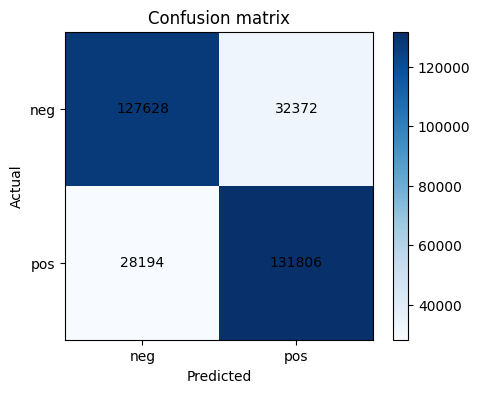

Saved model to: /content/drive/MyDrive/sentiment_project/models/sent140_logreg_tfidf.joblib


In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import joblib
from pathlib import Path

RANDOM_STATE = 42
TEST_SIZE = 0.2

X = df['text_clean']
y = df['label']

# stratify guard (ensure at least one sample per class in test)
n_samples = len(df)
n_classes = y.nunique()
n_test_desired = int(np.ceil(TEST_SIZE * n_samples))
if n_test_desired < n_classes:
    TEST_SIZE = max(n_classes / n_samples, 0.1)
    print("Adjusted TEST_SIZE to", TEST_SIZE)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y)

print("Train / Test sizes:", len(X_train), len(X_test))
print("Train label counts:\n", y_train.value_counts())
print("Test label counts:\n", y_test.value_counts())

# Vectorize
vect = TfidfVectorizer(max_features=20000, ngram_range=(1,2))
X_train_tfidf = vect.fit_transform(X_train)
X_test_tfidf = vect.transform(X_test)

# Train Logistic Regression (fast)
clf = LogisticRegression(max_iter=1000, solver='lbfgs')
print("Training LogisticRegression...")
clf.fit(X_train_tfidf, y_train)

# Evaluate
y_pred = clf.predict(X_test_tfidf)
print("\nClassification report:")
print(classification_report(y_test, y_pred, zero_division=0))
print("Accuracy:", accuracy_score(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
plt.imshow(cm, cmap='Blues')
plt.colorbar()
plt.xticks([0,1], ['neg','pos'])
plt.yticks([0,1], ['neg','pos'])
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i,j], ha='center', va='center')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion matrix")
plt.show()

# Save artifacts to Drive working folder
MODEL_DIR = Path("/content/drive/MyDrive/sentiment_project/models")
MODEL_DIR.mkdir(parents=True, exist_ok=True)
joblib.dump({'vect':vect,'clf':clf}, MODEL_DIR / "sent140_logreg_tfidf.joblib")
print("Saved model to:", MODEL_DIR / "sent140_logreg_tfidf.joblib")

In [ ]:
# Cell 6 - inference & interactive
import joblib, re
MODEL_PATH = "/content/drive/MyDrive/sentiment_project/models/sent140_logreg_tfidf.joblib"
bundle = joblib.load(MODEL_PATH)
vect, clf = bundle['vect'], bundle['clf']
print("Loaded model:", MODEL_PATH)

def preprocess_for_inference(s):
    s = str(s)
    s = re.sub(r"http\S+|www\S+", "", s)
    s = re.sub(r"@\w+", "", s)
    s = re.sub(r"[^A-Za-z0-9\s]", " ", s)
    s = re.sub(r"\s+", " ", s).strip().lower()
    return s

def predict_text(text, return_proba=True):
    x = preprocess_for_inference(text)
    Xv = vect.transform([x])
    pred = int(clf.predict(Xv)[0])
    probs = clf.predict_proba(Xv)[0] if hasattr(clf, 'predict_proba') else None
    return pred, probs

# Quick batch tests
tests = [
    "it is not great",
    "this product is amazing, very happy",
    "worst product ever",
    "okay product",
    "absolutely fantastic and works perfectly"
]
for t in tests:
    p, probs = predict_text(t)
    print(f"INPUT: {t}\n-> {p} ({'positive' if p==1 else 'negative'}), probs: {probs}\n")

# Interactive loop: uncomment if you want a REPL
while True:
    s = input("Enter text (or 'quit'): ")
    if s.strip().lower() in ('quit','exit'): break
    p, probs = predict_text(s)
    print("Prediction:", 'positive' if p==1 else 'negative', probs)

Loaded model: /content/drive/MyDrive/sentiment_project/models/sent140_logreg_tfidf.joblib
INPUT: it is not great
-> 0 (negative), probs: [0.7626543 0.2373457]

INPUT: this product is amazing, very happy
-> 1 (positive), probs: [0.01010604 0.98989396]

INPUT: worst product ever
-> 0 (negative), probs: [0.83554089 0.16445911]

INPUT: okay product
-> 1 (positive), probs: [0.18449983 0.81550017]

INPUT: absolutely fantastic and works perfectly
-> 1 (positive), probs: [0.01093648 0.98906352]

Prediction: negative [0.86223681 0.13776319]
Prediction: negative [0.86223681 0.13776319]
Prediction: positive [0.00686149 0.99313851]
Prediction: positive [0.16084809 0.83915191]
Prediction: positive [0.1371425 0.8628575]
Prediction: positive [0.3502895 0.6497105]
Prediction: positive [0.3502895 0.6497105]
Prediction: positive [0.3502895 0.6497105]
Prediction: positive [0.3502895 0.6497105]
Prediction: positive [0.31726883 0.68273117]
Prediction: negative [0.94274137 0.05725863]
Prediction: positive [